In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os

In [2]:
tf.__version__

'2.10.0'

In [20]:
# do image Augmentation to avoid over fitting

# rescale pixel values from [0, 255] to [-1, 1]
def changeRange(image):
    image[:, :, 0] = [(i/128.0)-1 for i in image[:, :, 0]]
    image[:, :, 1] = [(i/128.0)-1 for i in image[:, :, 1]]
    image[:, :, 2] = [(i/128.0)-1 for i in image[:, :, 2]]
    return image


train_datagen = ImageDataGenerator(rescale = None,         # normalize the data
                                   rotation_range = 40,      # randomly rotate images in the range 40 degrees
                                   width_shift_range = 0.2,  # randomly shift images horizontally 20%
                                   height_shift_range = 0.2, # randomly shift images vertically 20%
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   preprocessing_function= changeRange,
                                   fill_mode = 'nearest')

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (160, 160),
                                                 batch_size = 128,
                                                 class_mode = 'binary')


test_datagen = ImageDataGenerator(rescale = None,
                                  preprocessing_function= changeRange)
test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (160, 160),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


(-0.5, 336.5, 305.5, -0.5)

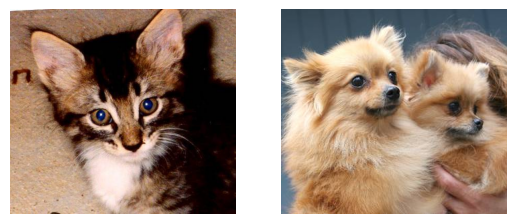

In [21]:
# plot the image
plt.subplot(121)
path = 'dataset/training_set/cats/cat.1027.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")

plt.subplot(122)
path = 'dataset/training_set/dogs/dog.77.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")

In [22]:
training_set.class_indices

{'cats': 0, 'dogs': 1}

# Base model
Create the base model from the pre-trained model MobileNet V2

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tf.keras.applications.MobileNetV3Small imposrt imposrt MobileNetV3Small
base_model = MobileNetV2(input_shape=(160,160,3),
                         include_top=False,   # exclude the last layer of the MobileNet V2
                         weights='imagenet')  # pre-training on ImageNet

# freeze the base model weights
base_model.trainable = False   

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


# Transfer learning
Concatenate the base model and the classification layer

In [26]:
# specify the shape of the input image
inputs = tf.keras.Input(shape=(160, 160, 3))
# freeze the base model weights
x = base_model(inputs, training=False) 
# convert the features to a single 1280-element vector per image.
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# include drop out to avoid overfitting
x = tf.keras.layers.Dropout(0.2)(x)
# classification layer
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# Compiling

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Training

In [28]:
history = model.fit(training_set,
                    epochs=10,
                    validation_data=test_set)

Epoch 1/10
63/63 [==============================] - 228s 4s/step - loss: 0.7080 - accuracy: 0.5961 - val_loss: 0.4724 - val_accuracy: 0.8105
Epoch 2/10
63/63 [==============================] - 165s 3s/step - loss: 0.4769 - accuracy: 0.7826 - val_loss: 0.3210 - val_accuracy: 0.9045
Epoch 3/10
63/63 [==============================] - 162s 3s/step - loss: 0.3633 - accuracy: 0.8561 - val_loss: 0.2432 - val_accuracy: 0.9335
Epoch 4/10
63/63 [==============================] - 166s 3s/step - loss: 0.2951 - accuracy: 0.8932 - val_loss: 0.1970 - val_accuracy: 0.9505
Epoch 5/10
63/63 [==============================] - 169s 3s/step - loss: 0.2564 - accuracy: 0.9111 - val_loss: 0.1680 - val_accuracy: 0.9555
Epoch 6/10
63/63 [==============================] - 174s 3s/step - loss: 0.2305 - accuracy: 0.9158 - val_loss: 0.1487 - val_accuracy: 0.9590
Epoch 7/10
63/63 [==============================] - 169s 3s/step - loss: 0.2128 - accuracy: 0.9235 - val_loss: 0.1345 - val_accuracy: 0.9635
Epoch 8/10
63

In [29]:
len(model.trainable_variables)

2

# Visualization 

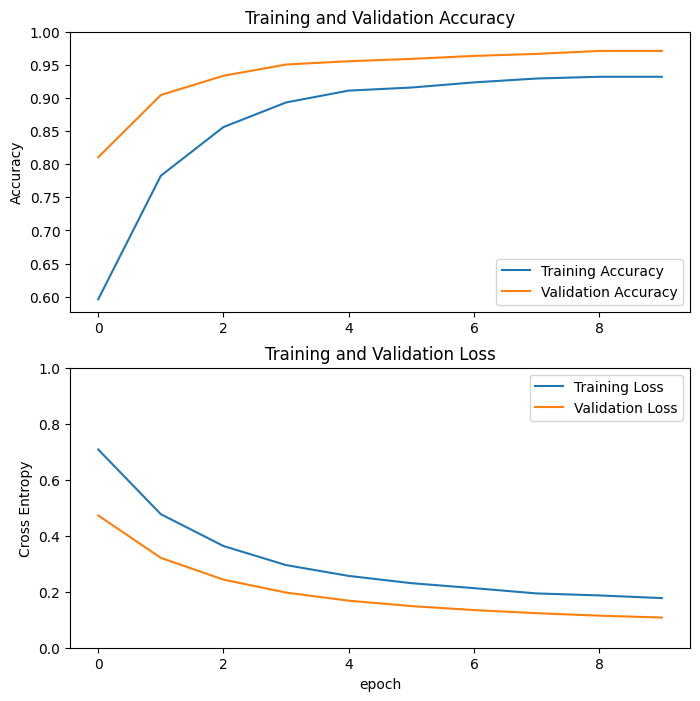

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [71]:
#  %tensorboard --logdir logs/fit

# Predict

(-0.5, 959.5, 719.5, -0.5)

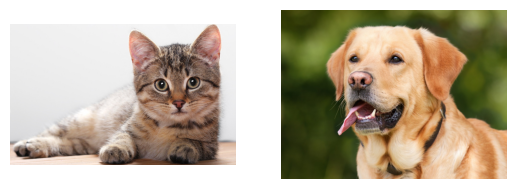

In [45]:
plt.subplot(121)
path = 'dataset/single_prediction/cats/cat.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")

plt.subplot(122)
path = 'dataset/single_prediction/dogs/dog.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis("off")

In [54]:
test_image = test_datagen.flow_from_directory('dataset/single_prediction',
                                               target_size = (160, 160))
predictions = model.predict(test_image)
predictions

Found 2 images belonging to 2 classes.
1/1 [==============================] - 0s 97ms/step


array([[0.9871293],
       [0.0199629]], dtype=float32)

In [55]:
predictions = tf.where(predictions < 0.5, 'cat', 'dog')
predictions

<tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'dog'],
       [b'cat']], dtype=object)>

# Fine tuning
Only Un-freeze the top layers of the model. Since lower layesr of the model learns very simple and generic features that generalize to almost all types of images.

In [56]:
# Among the 154 layers of the base model, fine-tune from this layer onwards
fine_tune_after = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_after]:
    layer.trainable = False

In [65]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),  # choose smaller learning rate
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainab

In [66]:
len(model.trainable_variables)

2

In [67]:
callbacks = [tf.keras.callbacks.EarlyStopping(
                                 monitor='val_loss',
                                 min_delta=1e-2,
                                 patience=2,
                                 verbose=1,
                                 )
            ]
history_fine = model.fit(training_set,
                         epochs=20,
                         initial_epoch=history.epoch[-1],
                         callbacks= callbacks,
                         validation_data=test_set)

Epoch 10/20
63/63 [==============================] - 148s 2s/step - loss: 0.1695 - accuracy: 0.9394 - val_loss: 0.1058 - val_accuracy: 0.9720
Epoch 11/20
63/63 [==============================] - 161s 3s/step - loss: 0.1701 - accuracy: 0.9373 - val_loss: 0.1047 - val_accuracy: 0.9720
Epoch 12/20
63/63 [==============================] - 169s 3s/step - loss: 0.1694 - accuracy: 0.9374 - val_loss: 0.1037 - val_accuracy: 0.9715
Epoch 12: early stopping


In [68]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

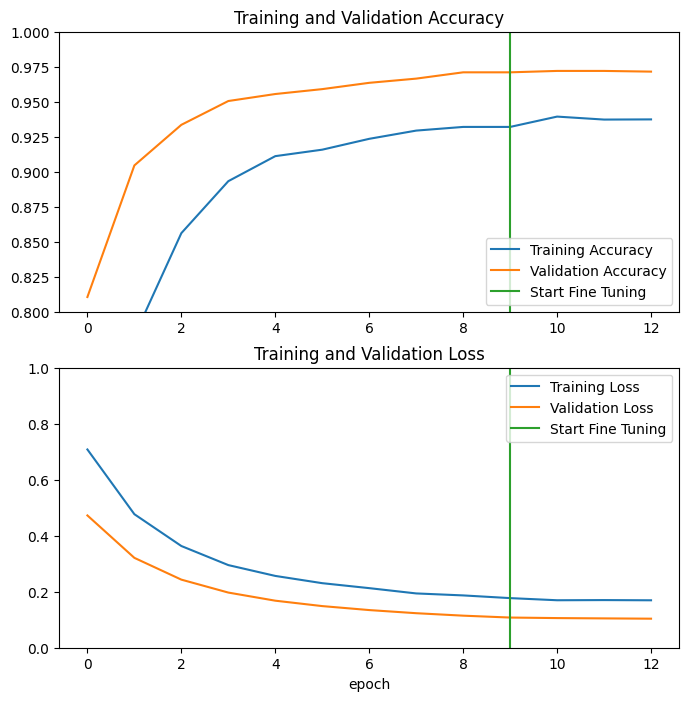

In [70]:
initial_epochs = 10
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()